<a href="https://colab.research.google.com/github/prasannashrestha011/ML_exercises/blob/main/CNN/std_colorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
import tensorflow_datasets as tfds
import tensorflow_io as tfio

/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

In [3]:
datasets,info=tfds.load("stl10",split=['train[:80%]','train[80%:]'],with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.VH3FG2_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.VH3FG2_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.VH3FG2_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_dataset,val_dataset=datasets
print("Train samples:", info.splits['train'].num_examples * 0.8)
print("Validation samples:", info.splits['train'].num_examples * 0.2)

Train samples: 4000.0
Validation samples: 1000.0


In [5]:
for example in train_dataset.take(1):
    image=example['image']
    label=example['label']
    print(image.shape)
    print(label)


(96, 96, 3)
tf.Tensor(1, shape=(), dtype=int64)


In [6]:
def preprocessing(sample):
    # Extract the image from the sample dict
    image = tf.cast(sample['image'], tf.float32) / 255.0

    # Resize
    image = tf.image.resize(image, [128, 128])

    # Remove alpha if exists
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    # Convert RGB -> LAB
    lab = tfio.experimental.color.rgb_to_lab(image)
    L = lab[:, :, 0:1] / 100.0
    ab = lab[:, :, 1:3] / 110.0

    return L, ab


In [7]:
train_dataset=train_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE)
val_dataset=val_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE=16

#loading next batch while training the current batch module
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for gray, target in train_dataset.take(1):
    print("Input (grayscale) shape:", gray.shape)
    print("Target (RGB) shape:", target.shape)


Input (grayscale) shape: (16, 128, 128, 1)
Target (RGB) shape: (16, 128, 128, 2)


In [9]:
def build_colorizer(input_shape=(128,128,1)):

  input_layer=layers.Input(shape=input_shape)
  x=layers.Conv2D(64,(3,3),activation='relu',padding='same')(input_layer)
  x=layers.MaxPool2D((2,2))(x)

  x=layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
  x=layers.MaxPool2D((2,2))(x)

  x=layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
  x=layers.UpSampling2D((2,2))(x)

  x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2,2))(x)

  output_layer=layers.Conv2D(2,(3,3),activation='tanh',padding='same')(x)
  model=models.Model(inputs=input_layer,outputs=output_layer)
  model.compile(optimizer='adam',loss='mae')
  model.summary()
  return model

In [10]:
model=build_colorizer()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 2)    │         2,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,010 (2.54 MB)

 Trainable params: 667,010 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs=20
history=model.fit(train_dataset,validation_data=val_dataset,epochs=epochs)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - loss: 0.0799 - val_loss: 0.0752
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - loss: 0.0760 - val_loss: 0.0753
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 0.0754 - val_loss: 0.0750
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 0.0749 - val_loss: 0.0746
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 0.0744 - val_loss: 0.0735
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 0.0740 - val_loss: 0.0733
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0736 - val_loss: 0.0732
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 0.0731 - val_loss: 0.0731
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0732 - val_loss: 0.0727
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0726 - val_loss: 0.0723
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 0.0723 - val_loss: 0.0722
Epoch 12/20
250/250 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


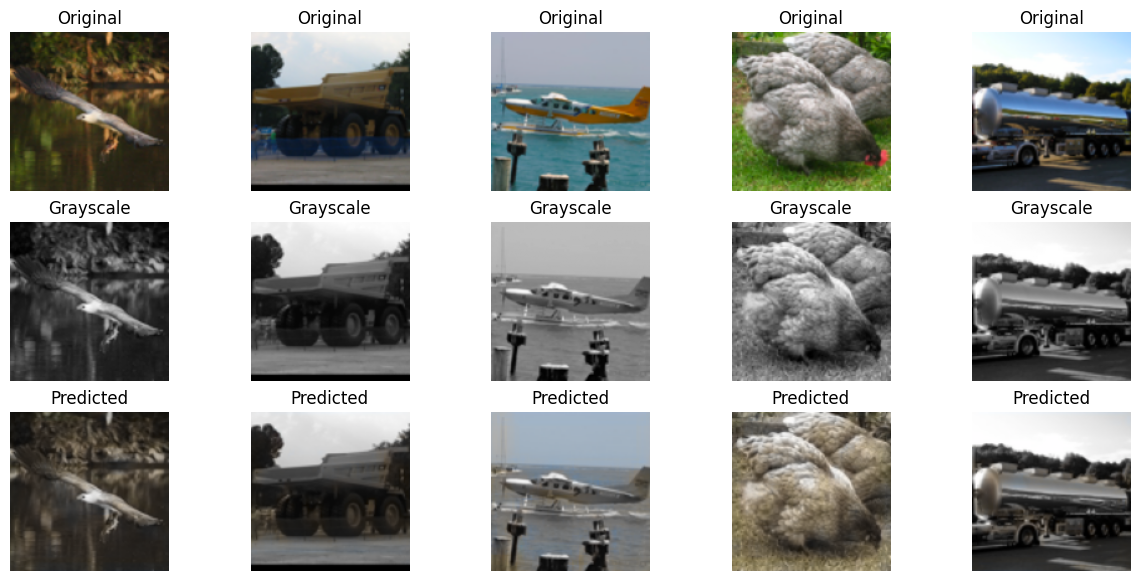

In [14]:
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf

# Take one batch from validation set
for L_batch, ab_batch in val_dataset.take(1):
    # Predict ab channels
    pred_ab = model.predict(L_batch)

# Model outputs are scaled with tanh [-1,1], rescale to original LAB range
pred_ab = pred_ab * 128.0

# L channel scaled to [0,100] for LAB
L_batch_scaled = L_batch * 100.0

# Combine L with predicted ab
pred_lab = tf.concat([L_batch_scaled, pred_ab], axis=-1)

# Convert LAB back to RGB
pred_rgb = tfio.experimental.color.lab_to_rgb(pred_lab)
pred_rgb = tf.clip_by_value(pred_rgb, 0.0, 1.0)

# Also convert ground-truth ab to RGB for comparison
ab_rgb = tfio.experimental.color.lab_to_rgb(tf.concat([L_batch_scaled, ab_batch * 128.0], axis=-1))
ab_rgb = tf.clip_by_value(ab_rgb, 0.0, 1.0)

# Convert tensors to numpy
pred_rgb = (pred_rgb.numpy() * 255).astype('uint8')
ab_rgb = (ab_rgb.numpy() * 255).astype('uint8')
L_batch_gray = (L_batch.numpy() * 255).astype('uint8')

# Display first 5 images
num_images = 5
plt.figure(figsize=(15,7))
for i in range(num_images):
    # Original color
    plt.subplot(3, num_images, i + 1)
    plt.imshow(ab_rgb[i])
    plt.title("Original")
    plt.axis('off')

    # Grayscale
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(L_batch_gray[i, :, :, 0], cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    # Predicted color
    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(pred_rgb[i])
    plt.title("Predicted")
    plt.axis('off')

plt.show()
